# How to make discoveries with ANTARES?


### Streaming epochal alerts from lightcurves of sources

Here we will be generating alerts - instances of positive or negative flux excursions at positions within the field of view of a hypothetical time-domain survey. For simplicity, consider the cadence of this survey to be two visits, separated by an hour, every second night. 

An alert would be constituted by its positions (RA, DEC) and nominal attributes: flux and flux error in magnitude unit, and the timestamp of the observation/epoch {basically a python tuple (RA,DEC,MJD,passband,mag,dmag). Note each alert is synonymous with a variation in flux or position of a source (We won't bother about possible contaminants in real data).

We would consider 10 epochs of observations, within a baseline of about 20 days. On each epoch, there would be a bunch of alerts that we would receive on which we are to design algorithm(s) that can efficiently and effectively throw out mundane stuffs from things one deems interesting. 

In this example, we would construct these alerts from lightcurves of real sources that we have collected from the OGLE 4 GSEP survey, covering ~5 sq. degrees around the South Ecliptic Pole (<a href="http://adsabs.harvard.edu/cgi-bin/nph-bib_query?db_key=AST&bibcode=2012AcA....62..219S">Soszyński et al., 2012, AcA, 62,219</a>) in the V and I passbands. Of course, the temporal sampling of these sources would be grossly different from our hypothetical survey. So, for our example, we would rather accept these sources as models 'quantized in time'. Simply, we would sample our alerts via plain linear interpolation of their available data. 

To demonstrate a aimple case of discovering something based on basic ANTARES design framework, we will ingest a fake source lightcurve making weird excursions (see the first figure below).

In [8]:
import numpy as np
import tables 
import os
import sys
%matplotlib notebook
import matplotlib.pyplot as plt
import sqlite3
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.coordinates import match_coordinates_sky
from astroquery.vizier import Vizier

Above we imported all python modules necessary for this exercise. 

<IPython.core.display.Javascript object>


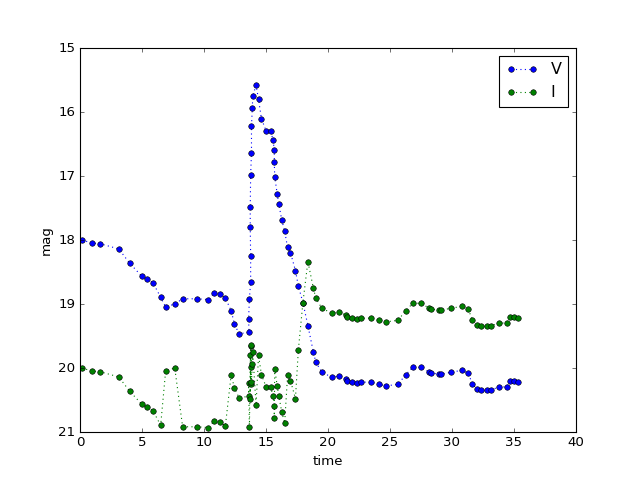

In [9]:
## Fake source
fake_ra=220.3020406
fake_dec=0.8037915
fake_id=999999
data=np.recfromcsv("fake.csv",names=True)
fake_t=data['t']
fake_v=data['v']
#fake_verr=np.random.normal(0.01, 0.1, len(data))
fake_i=data['i']
#fake_ierr=np.random.normal(0.02, 0.1, len(data))


# Plot the lightcurve
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(fake_t,fake_v,linestyle='dotted',marker='o',label="V",ms=5)
ax.plot(fake_t,fake_i,linestyle='dotted',marker='o',label="I",ms=5)
ax.set_xlabel("time")
ax.set_ylabel("mag")
plt.gca().invert_yaxis()
plt.legend()
plt.show()


We have now read in the fake source lightcurve. This is a lightcurve, whose morphology is based on <a href="http://oldtalk.planethunters.org/objects/APH21028451">here</a> (from the Planet Hunters project), but we grossly exaggerated details and faked the passbands including the lightcurve in the I band. 

In [10]:
# Read in the GSEP sources data, that include their sky coordinates, label and lightcurves. 
h5file=tables.open_file("./real_lcs_gsep.h5", mode="r")
raw_tbl=h5file.root.root_table1 
lc_tbl=h5file.root.lcurves.subgroup_table1
print (lc_tbl.colnames, raw_tbl.colnames, lc_tbl[0])

['LC_ID', 'mjd', 'hjd', 'mag', 'mag_err', 'passband'] ['ID', 'Survey', 'Field', 'RA', 'DEC', 'Classification', 'LC_ID'] (1, 0.0, 2455261.68372, 18.958, 0.036, b'I')


The real variable and transient sources from the OGLE4 GSEP survey are in the pytable "real_lcs_gsep.h5". The sample includes different kinds of variable stars and transients (e.g., long period variable, RR Lyrae, dwraf novae). Nice thing is, labels for majority of these sources are included in this table. So, later on, when you build a filter to select your object(s) of interest, you may verify. 


Below, we would build a simple database to ingest the alerts and perform the locus-association. The following is courtesy A. Miller from the <a href="https://github.com/LSSTC-DSFP/LSSTC-DSFP-Sessions">LSST-DSFP</a> that was held last month here in Tucson. This is an excellent source when looking for appropriate python tools for quick feasibility tests aimed toward time-domain astronomy big data. 

In [11]:
def DB_conn():
    conn = sqlite3.connect("miniANTARES.db")
    cur = conn.cursor()
    cur.execute("""drop table if exists Alert""")
    cur.execute("""create table Alert(
                    id integer primary key,
                    objId int,
                    ra float,
                    decl float,
                    t float, 
                    pb varchar(20),
                    mag float,
                    dmag float) 
    """)
    
    return conn, cur

In [12]:
def filt_coord(coord):
    #cmatch=SDSS.query_region(coord, radius=2.0*u.arcsec, spectro=True)
    Vizier.ROW_LIMIT=1
    cmatch=Vizier.query_region(my_obj,radius=2.0*u.arcsec,catalog='V/139/sdss9')
    flag_mtch=0
    if (len(cmatch)<1 or (len(cmatch)>0 and cmatch[0]['cl'][0]!=6)):
        flag_mtch=1
    return flag_mtch

def filt_jump(x,y):
    flag_jump=0
    x=np.array(x)
    y=np.array(y)
    y=y[np.argsort(x)]
    if (len(y)>1):
        dm=y[-1]-y[-2]
        if (np.abs(dm)>=3):
            flag_jump=1
    return flag_jump

Above we have defined two simple filters.The first, filt_coord captures information of association of an alert with a 'known' astro-object. In our case, we make use of this association information by flagging an alert only if it's not a star. For this exercise, we make use of the SDSS catalog. In the second filt_jump, we would flag down an alert if it exhibits variation between consecutive measurments greater than 3 mag. Of course, this is an ad-hoc filter designed to, not necessarily with an underlying physical model, fit the bill for our fake source.


In [13]:
passbands=[b'I',b'V']
N_epochs=10 #maximum number of epochs for this exercise 
interval_hrs=1.0/24.0
interval_fltrs=(10.0/60.0)/24.0
interval_days=2.0
Nalerts=5  

We have defined some parameters for our hypothetical survey. Basically we consider two passbands from the OGLE survey, I and V. To try to contain this exercise within the session, we go for 10 nightly epochs of observations.  On each observation night, two alert packets are issued per passband, separated by 1 hr. The interval between change of passbands is 10 mins. We visit after every second night. An alert packet contains 5 alerts. Remember an alert is a tuple of (ra,dec,time,passband,mag,dmag).


Below we will ingest the alert packets to the Alert database. As in Antares, this database is to be used for locus-association of the incoming alerts in real time. Here, we would demonstrate this process for just the fake source we ingested into the alert packets, whereby we will display its V-band (where the action will happen for our fake source) lightcurve as it gets assembled during our hypothetical survey. In principle, we know individual objects from its objid in our exercise, but we will ignore it and do actual locus-association.  

We will pass each alert coming from this fake source to the the filters defined above and flag it down the instant it meets both conditions. 

<IPython.core.display.Javascript object>


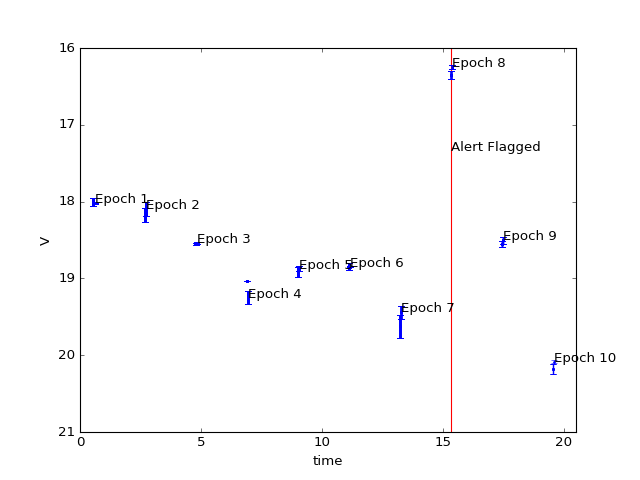

Alert is Oddball


In [14]:
plt.ion()
fig=plt.figure()
ax=fig.add_subplot(111)
ax.set_xlabel("time")
ax.set_ylabel("V")
ax.set_ylim(21.0,16.0)
ax.set_xlim(0.0,20.5)


to_plot_x=[]
to_plot_y=[]
to_plot_yerr=[]


conn,cur=DB_conn()
time_stamp=0.5-(interval_days)  #time-stamp initialization
for i in range(N_epochs):
    time_stamp=time_stamp+interval_days
    for H in range(2):
        time_stamp=time_stamp+interval_hrs
        for p in passbands:
            time_stamp=time_stamp+interval_fltrs
            mask_p=(lc_tbl[:]['passband']==p)
            ids=lc_tbl[:]['LC_ID'][mask_p]
            t=lc_tbl[:]['hjd'][mask_p]
            mag=lc_tbl[:]['mag'][mask_p]
            dmag=lc_tbl[:]['mag_err'][mask_p]
            #print (len(ids),len(raw_tbl), len(lc_tbl), len(temp), type(temp))
            chosen_ids=np.random.choice(np.unique(ids), Nalerts, replace=False)
            in_data=[]
            for alert_id in chosen_ids:
                mask_id=ids==alert_id
                x=t[mask_id]
                y=mag[mask_id]
                yerr=dmag[mask_id]
                M=np.argsort(x)
                x=x[M]
                y=y[M]
                yerr=yerr[M]
                y_in=np.interp(time_stamp,x-x[0],y)
                yerr_in=np.interp(time_stamp,x-x[0],yerr)
                y_in += np.random.normal(0.,yerr_in)
                mask2=raw_tbl[:]['LC_ID']==alert_id
                coord=SkyCoord(raw_tbl[:]['RA'][mask2][0].decode(),raw_tbl[:]['DEC'][mask2][0].decode(),unit=(u.hourangle, u.deg))
                #in_data.append((alert_id,coord.ra.degree,coord.dec.degree,time_stamp,p.decode(),y_in,yerr_in))
                ## dithering the ra,dec around the real values by sigma=1"
                dithered_ra=np.random.normal(coord.ra.degree,1.0/3600.0,1)[0]
                dithered_dec=np.random.normal(coord.dec.degree,1.0/3600.0,1)[0]
                in_data.append((alert_id,dithered_ra,dithered_dec,time_stamp,p.decode(),y_in,yerr_in))
                
                #print (alert_id,raw_tbl[:]['LC_ID'][mask2],coord.ra.degree,coord.dec.degree,dithered_ra,dithered_dec)
            if (p==b'V'):
                fake_mag=np.interp(time_stamp,fake_t,fake_v)
                fake_dmag=np.abs(np.random.normal(0.01,0.05))
                fake_mag += np.random.normal(0.,fake_dmag)
                to_plot_x.append(time_stamp)
                to_plot_y.append(fake_mag)
                to_plot_yerr.append(fake_dmag)
            else:
                fake_mag=np.interp(time_stamp,fake_t,fake_i)
                fake_dmag=np.abs(np.random.normal(0.01,0.05))
                fake_mag += np.random.normal(0.,fake_dmag)
                
            dithered_ra_fake=np.random.normal(fake_ra,1.0/3600.0,1)[0]
            dithered_dec_fake=np.random.normal(fake_dec,1.0/3600.0,1)[0]
            in_data.append((fake_id,dithered_ra_fake,dithered_dec_fake,time_stamp,p.decode(),fake_mag,fake_dmag))
           # print ("pushing for epoch {0}, {1} out of 2 nightly visits, alert packet for passband {2} at time {3}".format(i+1,H+1,p,time_stamp))
            
            my_obj=SkyCoord(np.array([dithered_ra_fake]),np.array([dithered_dec_fake]), unit=(u.degree, u.degree))

            stage1=filt_coord(my_obj)
            
            cur.execute("""select ra, decl, t, pb, mag, dmag from Alert""")
            bingo=cur.fetchall()
            bingo=np.array(bingo)
            if (len(bingo)>0):
                catalog = SkyCoord(bingo[:,0], bingo[:,1], unit=(u.degree, u.degree))
                idx_my_obj, idx_catalog, sep, d3d = catalog.search_around_sky(my_obj, 2.0*u.arcsec)  
                if (len(idx_catalog)>0):
                    matches=bingo[idx_catalog]
                    mask=matches[:,3]=='V'
                    to_plot_x=to_plot_x+list(matches[:,2].astype(float)[mask])
                    to_plot_y=to_plot_y+list(matches[:,4].astype(float)[mask])
                    to_plot_yerr=to_plot_yerr+list(matches[:,5].astype(float)[mask])

            stage2=filt_jump(to_plot_x,to_plot_y) 
            
            X=np.array(to_plot_x)
            Y=np.array(to_plot_y)
            Z=np.array(to_plot_yerr)
            
            orderd=np.argsort(X)
            X=X[orderd]
            Y=Y[orderd]
            Z=Z[orderd]
            
            if (len(X)>0 and p==b'V'):  ##since we are plotting only the V data    
                ax.errorbar(X,Y,yerr=Z,linestyle='None',color='blue')
                ax.scatter(X,Y,marker='o',color='blue',s=2)
                #print (stage1, stage2)
                if (stage1==1 and stage2==1):
                    print ("Alert is Oddball")
                    ax.vlines(time_stamp,21.0,16.0,color='red')
                    ax.annotate('Alert Flagged',(X[-1],Y[-1]), (X[-1],Y[-1]+1.0))
                if (H==1):
                    ax.annotate('Epoch %s'%str(i+1),(X[-1],Y[-1]))
                    
                    
                fig.canvas.draw()
            cur.executemany("""insert into Alert(objId, ra, decl, t, pb, mag, dmag) values (?,?,?,?,?,?,?)""", in_data)
            conn.commit()
conn.close()

# Challenge

How about designing some filters, based on the above exercise, to select your object of inteest?